In [1]:
from shared_notebook_utils import *
from statsmodels.sandbox.stats.runs import mcnemar
seaborn.set(style="whitegrid")
%matplotlib inline
dataset_dirnames = ['iowa_instrument_samples', 'carlos_vaquero_instrument_samples', 'philharmonic_orchestra_samples', 'nsynth-test', 'nsynth-valid', 'good-sounds'] 
datasets = load_datasets(dirnames=dataset_dirnames, clean=True)
methods_to_compare = ['EssentiaPitchYin','ACExtractorV1', 'QMULpyin']
accuracy_functions = [exact_match, pitch_class]
accuracy_functions_names = ['Exact', 'PitchClass']

DISPLAY_NAMES = {
    'ACExtractorV1': 'ACExtractorV1',
    'QMULpyin': 'QMULPYin',
    'EssentiaPitchYinFFT': 'ESSPYinFFT',
    'EssentiaPitchYin': 'ESSPYin',
}


Basic statistics per dataset
----------------------------

Dataset   N       T. Duration   Mean Duration   Durations range   
------------------------------------------------------------------
IOWA      415     0h 18m        2.68s           0.14s - 7.73s     
CVAQ      391     0h 23m        3.62s           1.01s - 8.28s     
PHIL      5462    2h 26m        1.61s           0.08s - 45.61s    
NSYT      4096    4h 33m        4.00s           4.00s - 4.00s     
NSYV      12678   14h 5m        4.00s           4.00s - 4.00s     
GSND      8141    14h 34m       6.45s           0.48s - 33.65s    


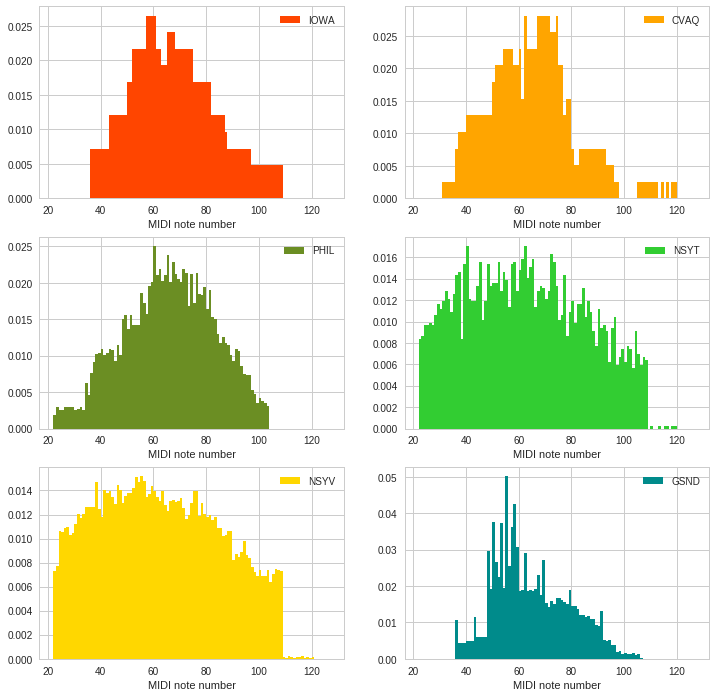

In [5]:
table_header = ['Dataset', 'N', 'T. Duration', 'Mean Duration', 'Durations range']
table_rows = list()
genres = dict()

for dataset in datasets:
    row = [dataset.short_name]
    row.append(len(dataset.data))
    durations = dataset.get_data('analysis.durations.duration')
    if durations:
        durations = np.array(durations)
        row.append('%ih %im' % (int(durations.sum()) / 3600, int(durations.sum() % 3600) / 60))
        row.append('%.2fs' % durations.mean())
        row.append('%.2fs - %.2fs' % (durations.min(), durations.max()))
    table_rows.append(row)

print(title('Basic statistics per dataset'))
print_table(table_header, table_rows, highlight_max=False)

# Pitch histograms
fig1, axs = plt.subplots(3, 2, figsize=(12, 12))
for count, dataset in enumerate(datasets):
    notes = dataset.get_data('annotations.midi_note')
    min_p = 22
    max_p = 127
    ax = axs[count//2,count%2]
    ax.hist(notes, bins=max_p-min_p, range=(min_p,max_p), normed=True, label=dataset.short_name, color=COLORS[count])
    ax.set_xlabel('MIDI note number')
    ax.legend()
plt.show()



General pitch estimation results (IOWA)
****************************************


Method          Exact   PitchClass   
-------------------------------------
ACExtractorV1   70.60   73.25        
QMULPYin        64.58   68.43        
ESSPYin         64.34   67.95        


General pitch estimation results (CVAQ)
****************************************


Method          Exact   PitchClass   
-------------------------------------
QMULPYin        41.69   63.94        
ACExtractorV1   34.53   53.45        
ESSPYin         27.37   41.43        


General pitch estimation results (PHIL)
****************************************


Method          Exact   PitchClass   
-------------------------------------
QMULPYin        52.73   55.62        
ACExtractorV1   51.17   53.66        
ESSPYin         46.12   48.90        


General pitch estimation results (NSYT)
****************************************


Method          Exact   PitchClass   
-------------------------------------
QMULPYin      

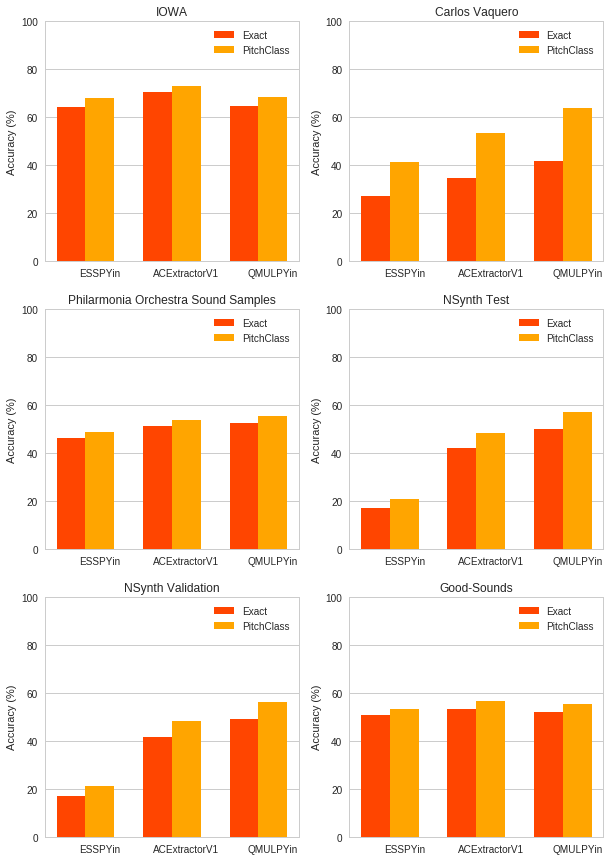

In [6]:
all_datasets_method_results = dict()
fig1, axs = plt.subplots(3, 2, figsize=(10, 15))
for count, dataset in enumerate(datasets):
    print(title("\nGeneral pitch estimation results (%s)" % dataset.short_name, c='*'))
    table_header = ['Method'] + accuracy_functions_names
    table_rows = list()

    for method in methods_to_compare:
        if method not in all_datasets_method_results:
            all_datasets_method_results[method] = dict()
        try:
            table_row = [DISPLAY_NAMES.get(method, method)]
            for accuracy_func in accuracy_functions:
                method_results = accuracy_func(dataset.data, method)
                table_row.append(100 * basic_statistics(method_results)['avg'])
                if accuracy_func.__name__ not in all_datasets_method_results[method]:
                    all_datasets_method_results[method][accuracy_func.__name__] = list()
                all_datasets_method_results[method][accuracy_func.__name__] += method_results
            table_rows.append(table_row)
        except IndexError:
            print("Warning: Skipping method %s (analsyis not found in dataset)" % method)
            continue
    print("")
    print_table(table_header, table_rows, sort_column=1, highlight_max=True)
    
    # Plot results
    ax = axs[count//2,count%2]
    N = len(methods_to_compare)
    ind = np.arange(N)
    rects = list()
    width = 1.0 / (len(accuracy_functions) + 1)
    for i in range(0, len(accuracy_functions)):
        means = [row[i+1] for row in table_rows]
        rects.append(ax.bar(ind + i * width, means, width, color=COLORS[i]))
    ax.set_title(dataset.name)
    ax.set_xticks(ind + (width * len(accuracy_functions) * 1.0)/2)
    ax.set_xticklabels([DISPLAY_NAMES.get(method, method) for method in methods_to_compare], rotation=0)
    ax.legend([rect[0] for rect in rects], accuracy_functions_names)
    ax.set_ylabel('Accuracy (%)')
    ax.set_ylim((0, 100))
    ax.xaxis.grid(False)

In [8]:
print(title("General pitch estimation results (ALL DATASETS)"))
table_header = ['Method'] + accuracy_functions_names + ['Mean accuracy']
table_rows = list()
for method, results in all_datasets_method_results.items():
    table_row = [DISPLAY_NAMES.get(method, method)]
    for accuracy_measure in [f.__name__ for f in accuracy_functions]:
        data = results[accuracy_measure]
        table_row.append(100 * basic_statistics(data)['avg'])
    table_rows.append(table_row + [np.mean(table_row[1:])])
print_table(table_header, table_rows, sort_column=-1, highlight_max=True)


General pitch estimation results (ALL DATASETS)
-----------------------------------------------

Method          Exact   PitchClass   Mean accuracy   
-----------------------------------------------------
QMULPYin        50.83   56.38        53.60           
ACExtractorV1   46.64   51.70        49.17           
ESSPYin         31.66   35.30        33.48           


In [11]:
# Run pairwise statistical tests
alpha = 0.01

def compute_mcnemar_test(method1_data, method2_data):
    stat, pvalue = mcnemar(method1_data, method2_data, exact=False)
    if pvalue < alpha:
        return "%.3g*" % pvalue
    return "%.3g" % pvalue

for count, dataset in enumerate(datasets):
    print("")
    print(title('Statistical tests for dataset %s' % dataset.short_name))
    for accuracy_func in accuracy_functions:
        print('\nMeasure: %s' % accuracy_func.__name__)
        table_header = [' '] + [DISPLAY_NAMES.get(method, method) for method in methods_to_compare]
        table_rows = list()
        for method_a in methods_to_compare:
            table_row = list()
            for method_b in methods_to_compare:
                if method_a != method_b:
                    result = compute_mcnemar_test(accuracy_func(dataset.data, method_a), accuracy_func(dataset.data, method_b))
                    table_row.append(result)
                else:
                    table_row.append('-')
            table_rows.append([DISPLAY_NAMES.get(method_a, method_a)] + table_row)
        print_table(table_header, table_rows)



Statistical tests for dataset IOWA
----------------------------------


Measure: exact_match
                ESSPYin     ACExtractorV1   QMULPYin   
-------------------------------------------------------
ESSPYin         -           0.000308*       1          
ACExtractorV1   0.000308*   -               0.00497*   
QMULPYin        1           0.00497*        -          

Measure: pitch_class
                ESSPYin    ACExtractorV1   QMULPYin   
------------------------------------------------------
ESSPYin         -          0.00765*        0.897      
ACExtractorV1   0.00765*   -               0.0293     
QMULPYin        0.897      0.0293          -          


Statistical tests for dataset CVAQ
----------------------------------


Measure: exact_match
                ESSPYin     ACExtractorV1   QMULPYin    
--------------------------------------------------------
ESSPYin         -           0.000134*       4.74e-10*   
ACExtractorV1   0.000134*   -               0.00106*    
QMULP